### Mini-Lab Logistic Regression & SVMs
Authors: Dan Davieau, Paul Panek, Olga Tanyuk, Nathan Wall

The analysis below is to develop several models to predict the probablity of default for credit card customers.We will be focusing on logistic regression and SVM models using various options in sklearn. 

In order to assess our model we will begin by reading in the data and performing some of the data transformations that we documented in Lab 1.


In [125]:
#import the data
import pandas as pd
import numpy as np

#read the data in
df = pd.read_csv('C:/Users/bsnxw01/Desktop/MSDS_Program/MSDS_7331/Project/Lab1/DataMiningGroupProjects/Project1/Input/DefaultCreditcardClients.csv')

#convert default to default name
df.rename(columns={'default payment next month':'default'}, inplace=True)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#transform continuous variables as they each have a mostly exponential distribution
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
# assign zero to na to not get error on log transform then assign the zero values back to zero
df[continuous_features] = df[continuous_features].replace(to_replace=0,value=np.nan).apply(np.log).replace(to_replace=np.nan,value=0)

#bin the ages based on various age groups 
bins = [18, 25, 35, 45, 55, 65, 100]
labels = [0,1,2,3,4,5]
df['AGEGROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels)

#flag all the payment histor to late vs not late
payments = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
bins = [-10, 1, 10]
labels = [0,1]
for fi,feature in enumerate(payments):
    df[feature] = pd.cut(df[feature], bins=bins, labels=labels).astype(np.int)
#count how many total late payments have been made
df['TotalLatePayments'] = df[payments].sum(axis=1)

#get the avg bill amt
bill_amt = ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
df['AvgBillAmt'] = df[bill_amt].mean(axis=1)

#get the avg pay amt
pay_amt = ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']
df['AvgPayAmt'] = df[pay_amt].mean(axis=1)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 29 columns):
ID                   30000 non-null int64
LIMIT_BAL            30000 non-null float64
SEX                  30000 non-null int64
EDUCATION            30000 non-null int64
MARRIAGE             30000 non-null int64
AGE                  30000 non-null int64
PAY_0                30000 non-null int32
PAY_2                30000 non-null int32
PAY_3                30000 non-null int32
PAY_4                30000 non-null int32
PAY_5                30000 non-null int32
PAY_6                30000 non-null int32
BILL_AMT1            30000 non-null float64
BILL_AMT2            30000 non-null float64
BILL_AMT3            30000 non-null float64
BILL_AMT4            30000 non-null float64
BILL_AMT5            30000 non-null float64
BILL_AMT6            30000 non-null float64
PAY_AMT1             30000 non-null float64
PAY_AMT2             30000 non-null float64
PAY_AMT3             30000 non-nu

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,TotalLatePayments,AvgBillAmt,AvgPayAmt
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,11.663002,1.603733,1.842267,1.557267,35.485500,0.104333,0.147000,0.140300,0.116933,...,6.628429,6.560799,6.281239,6.075454,6.030313,5.931124,0.221200,0.710133,8.624109,6.251226
std,8660.398374,0.941135,0.489129,0.744494,0.521405,9.217904,0.305698,0.354112,0.347304,0.321346,...,3.252039,3.280914,3.351656,3.398790,3.445665,3.529484,0.415062,1.464712,3.123457,2.461844
min,1.000000,9.210340,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,10.819778,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,6.907755,6.725034,5.966147,5.690359,5.531405,4.768557,0.000000,0.000000,7.107727,5.025010
50%,15000.500000,11.849398,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,7.649693,7.605392,7.495542,7.313220,7.313220,7.313220,0.000000,0.000000,9.708304,6.924126
75%,22500.250000,12.388394,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,8.518392,8.517193,8.412943,8.297357,8.301894,8.294050,0.000000,1.000000,10.826377,8.032059
max,30000.000000,13.815511,2.000000,4.000000,3.000000,79.000000,1.000000,1.000000,1.000000,1.000000,...,13.680323,14.336836,13.705740,13.339086,12.963436,13.178112,1.000000,6.000000,13.664303,12.752655


#### One-hot encoding the categorical data
From above we are able to see that we 31 features of mixed type (categorical & continuous) that we will be using to predict our the class of our target, "default". In order to use the categorical variables we will encode them using one hot encoding.

For this we will be encoding Education, Marriage, Agegroup, Pay_0-Pay_6. Sex does not need encoded as there are only 2 categories.

_*We will will also go ahead and remove the ID variable as it won't be used in our predictions_

In [107]:
df['TotalLatePayments'].value_counts()

0.0    21620
1.0     3494
2.0     1567
3.0     1073
6.0      938
4.0      711
5.0      597
Name: TotalLatePayments, dtype: int64

In [126]:
# Change numeric values to floats
numVar = df[['LIMIT_BAL', 'BILL_AMT1','PAY_AMT1','PAY_0','TotalLatePayments','AvgBillAmt','AvgPayAmt']]

targetVar = df['default']

# One hot encodings the categorical variables
charVar = ['EDUCATION', 'MARRIAGE','AGEGROUP']
tmp_df = pd.get_dummies(df[charVar].astype('category'))

df = pd.concat((numVar, tmp_df, targetVar),axis=1) # add back into the dataframe

print(df.shape)
df.info()

(30000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 21 columns):
LIMIT_BAL            30000 non-null float64
BILL_AMT1            30000 non-null float64
PAY_AMT1             30000 non-null float64
PAY_0                30000 non-null int32
TotalLatePayments    30000 non-null int64
AvgBillAmt           30000 non-null float64
AvgPayAmt            30000 non-null float64
EDUCATION_1          30000 non-null uint8
EDUCATION_2          30000 non-null uint8
EDUCATION_3          30000 non-null uint8
EDUCATION_4          30000 non-null uint8
MARRIAGE_1           30000 non-null uint8
MARRIAGE_2           30000 non-null uint8
MARRIAGE_3           30000 non-null uint8
AGEGROUP_0           30000 non-null uint8
AGEGROUP_1           30000 non-null uint8
AGEGROUP_2           30000 non-null uint8
AGEGROUP_3           30000 non-null uint8
AGEGROUP_4           30000 non-null uint8
AGEGROUP_5           30000 non-null uint8
default              30000 no

#### Splitting the training/test data set

After encoding the data we now have 96 features that we will be using to predict our the class of our target, "default". There are 30,000 observations in this dataset that we split into training/test sets (80/20 split) that we can use to assess the performance of our two models.

In [127]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'default' in df:
    y = df['default'].values # get the labels we want
    del df['default'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
      
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

print("Dimensions of training features are " , X_train.shape)
print("Dimensions of training target are " , y_train.shape)
print("Dimensions of testing features are " , X_test.shape)
print("Dimensions of testing target are " , y_test.shape)

Dimensions of training features are  (24000, 20)
Dimensions of training target are  (24000,)
Dimensions of testing features are  (6000, 20)
Dimensions of testing target are  (6000,)


#### Scale the data
From above we see that we succesfully split our training/test sets split up 80/20 with 24000 obs in the training data and 6000 in our test set.

Once we have our datasets split up we can now use our training data to calculate the mean & standard deviation to scale our continuous variables. It is important to not let the values from the test data be used in the calculation of the mean & standard deviation as this may accidently provide you insights into the test data that you should not have in your model training.

In [128]:
from sklearn.preprocessing import StandardScaler
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


#### Fitting the Logistic Regression Model
After we scale our train & test sets we can start training our models. We will begin by training the Logisitc Regression model and explore the various options to assess the models performance.

Our first logistic model will begin by using the default logistic regression paramertes from the scikitlearns logistic model.

accuracy 0.8173333333333334
confusion matrix
 [[4501  179]
 [ 917  403]]
EDUCATION_4 has weight of -0.5266471149784026
LIMIT_BAL has weight of -0.18513351186934404
AvgPayAmt has weight of -0.175310093321993
BILL_AMT1 has weight of -0.06428842862794766
PAY_AMT1 has weight of -0.03399916666420435
AGEGROUP_1 has weight of 0.0064036624302471635
AGEGROUP_0 has weight of 0.07444017456230266
AGEGROUP_2 has weight of 0.09033530903861028
AvgBillAmt has weight of 0.10749524956242282
MARRIAGE_2 has weight of 0.14231760073698624
AGEGROUP_4 has weight of 0.15051655139977083
AGEGROUP_5 has weight of 0.16702233214254109
AGEGROUP_3 has weight of 0.1734468783332037
MARRIAGE_3 has weight of 0.22412377229084582
TotalLatePayments has weight of 0.24811934216025905
MARRIAGE_1 has weight of 0.2957235348784709
EDUCATION_3 has weight of 0.3271879367380568
EDUCATION_1 has weight of 0.4136649754322847
EDUCATION_2 has weight of 0.44795911071419503
PAY_0 has weight of 1.5617068001476622


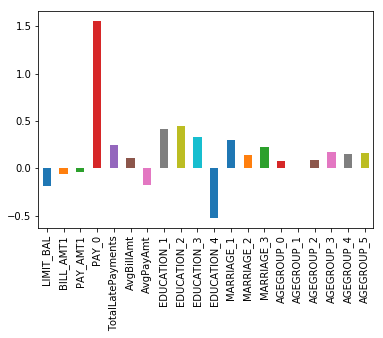

In [129]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

lr = LogisticRegression() # get object
# train the reusable logisitc regression model on the training data
lr.fit(X_train,y_train)  # train object
y_hat = lr.predict(X_test) # get test set precitions

# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

# sort these attributes and spit them out
zip_vars = zip(lr.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
weights = pd.Series(lr.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()